# Fighting California forest fires using spatial analysis

The state of California has had a dangerous fire season in 2015 and 2016. A standard procedure while fighting these fires is identifying facilities that are at risk and evacuating them. Tasks such as this can be accomplished easily using **spatial analysis** tools available on your GIS. Spatial analysis tools allow overlaying the extent of fire and the locations of the facilities on a map and identifying the ones that fall within the fire's extent.

Thus, this sample demonstrates the application of spatial analysis tools such as **buffer and overlay**.

This notebook describes a scenario wherein an analyst automates the process of identifying facilities at risk from forest fires and sharing this information with other departments such as the fire department, etc.


In [27]:
import datetime
import arcgis
from arcgis.gis import GIS
from IPython.display import display
from getpass import getpass

password = getpass()

# create a Web GIS object
gis = GIS("https://esriwebgis.webgistesting.net/portal", "atma.mani", password)

········


## Visualize the fire data
Let us create a map widget to see the fire related information in it's geographic context:

In [28]:
fire_layers_search = gis.content.search('fire* & owner:atma.mani', item_type='Feature Layer')
fire_layers_search

[<Item title:"CA_Fires_facilities" type:Feature Service owner:atma.mani>,
 <Item title:"Fire_Buffers_2017_03_10_10_40_56" type:Feature Service owner:atma.mani>]

<Item title:"CA_Fires_facilities" type:Feature Service owner:atma.mani>
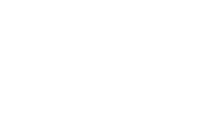

In [29]:
ca_fires = fire_layers_search[0]
ca_fires

In [30]:
# create a map of our area of interest
m = gis.map('Los Angeles', 9)
m

In [31]:
# add our critical infrastructure layer
infra = ca_fires.layers[0]
m.add_layer(infra)

In [32]:
# add the active fires layer
fires = ca_fires.layers[1]
m.add_layer(fires)

## Create buffers around fires

In [33]:
from arcgis.features.use_proximity import create_buffers

# buffer the active fire boundaries and add as new content

timestamp = '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now())
firebuffers = create_buffers(input_layer = fires, 
                             distances=[4], 
                             field=None, 
                             units='Miles', 
                             output_name="Fire_Buffers_" + timestamp )

Submitted.
Executing...


The output layer is private by default. To share it with particular groups, members within the org,  or everyone, we can use the `Item.share()` method. The code below shares it to everyone (public):

In [34]:
# share the layer with public
firebuffers.share(everyone = True)

{'itemId': 'cebff18c3a364dafbcc98aa6ed5fe051', 'notSharedWith': []}

Since the `output_name` parameter was specified, the tool created a new feature layer item as output. We can visualize this by adding it to the map above. Now we can observe more facilities falling within the buffered area.

In [35]:
# add risk areas to map
m.add_layer(firebuffers)

## Perform overlay analysis to extract facilities that fall within the fire buffers

To programattically extract the locations that fall within the fire buffers, we use **`overlay_layers`** tool under `FeatureAnalysisTools` class just like we did for `create_buffers` tool earlier. The overlay layers tool supports a few overlay types, here we use **`Intersect`** as we need to perform a spatial intersection to identify the facilities that are located within the fire boundaries. To learn more about this operation, refer to the [documentation](https://developers.arcgis.com/rest/analysis/api-reference/overlay-layers.htm).

We specify an output name (with a timestamp) for the service as we want to keep a record of the critical infrastructure within the risk boundaries and share it with others as feature layers or in web maps:

In [36]:
from arcgis.features.manage_data import overlay_layers

# run analysis to determine critical infrastructure within the risk boundaries
riskinfra = overlay_layers(input_layer=firebuffers, overlay_layer=infra, 
                        overlay_type="Intersect",
                        output_name="At_Risk_Infrastructure_" + timestamp)

Submitted.
Executing...


In [37]:
# set sharing on new analysis layer
riskinfra.share(True)

{'itemId': '82c2e60a3b1b4b4fb527d57a6fa3a10d', 'notSharedWith': []}

The output of the overlay analysis is a Feature Layer Item. We can access the layers and tables in an Item representing GIS services using the `layers` and `tables` attributes. 

In [38]:
riskinfra.layers

[<FeatureLayer url:"http://ESRIwebgis.webgistesting.net/server/rest/services/Hosted/At_Risk_Infrastructure_2017_03_10_13_22_52/FeatureServer/0">]

## Read analysis results as a pandas dataframe for analysis


Let us read this results of the overlay analysis by querying it's layer for attribute data, and display the attribute table to get a sense of the results. Layers can be queried for attributes and geometry using the `query()` method.

The query we ran in the previous step returned a list of dictionaries representing the features. For further analysis or for visualizing the output data as a table, let us convert it into a [pandas](http://pandas.pydata.org/) [dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [39]:
at_risk_facilities  = riskinfra.layers[0]
risk_fset = at_risk_facilities.query()

df = risk_fset.df # read the returned features as a Pandas dataframe
df

,acres,addrln1,addrln2,analysisarea,buff_dist,cat1,cat2,cat3,city,containmen,...,post_id,source,state,status,target_fid,url,use_type,zip,geometry.x,geometry.y
objectid_1,,,,,,,,,,,,,,,,,,,,,
1,10850,,,112.459570,4.0,Physical Features,Power Plants,,,0.50,...,24626.0,HSIP Freedom Gnis_cultural_fe,,Active,15,,publish,,-1.312145e+07,4.052550e+06
2,1080,,,57.433120,4.0,Health and Mental Health,Hospitals and Medical Centers,,,0.65,...,26620.0,HSIP Freedom Gnis_structures,,Active,17,,publish,,-1.320652e+07,4.049971e+06
3,8940,,,60.135538,4.0,Health and Mental Health,Hospitals and Medical Centers,,,0.80,...,27055.0,HSIP Freedom Gnis_structures,,Active,48,,publish,,-1.317837e+07,4.066587e+06
4,8940,12653 Osborne St.,,60.135538,4.0,Transportation,Airports,,Pacoima,0.80,...,13559.0,Current Services Locator,CA,Active,57,,publish,91331,-1.318171e+07,4.063658e+06
5,1080,5601 De Soto Ave.,,57.433120,4.0,Health and Mental Health,Hospitals and Medical Centers,911 Receiving,Woodland Hills,0.65,...,730.0,Current Services Locator,CA,Active,59,www.kaiserpermanente.org,publish,91365,-1.320135e+07,4.051785e+06
6,8940,9449 San Fernando Rd.,,60.135538,4.0,Health and Mental Health,Hospitals and Medical Centers,911 Receiving,Sun Valley,0.80,...,637.0,211,CA,Active,166,www.pacificahospital.com,publish,91352,-1.317981e+07,4.061095e+06
7,8940,12756 Van Nuys Blvd,,60.135538,4.0,Health and Mental Health,Hospitals and Medical Centers,,Pacoima,0.80,...,70599.0,211,CA,Active,218,www.nevhc.org/,publish,91331,-1.318142e+07,4.065676e+06


From the data frame, we can see there are 7 features which fell within the fire buffers. To make this result usable, let us export a CSV with only the facility name and other critical details. This CSV can be considered as a valuable information product as a result of this analysis and can be shared with the teams assisting in organizing the firefighting efforts, evacuations, etc.

In [40]:
# view simplified risk facilities table
df1_simplified = df[['name', 'cat1', 'post_id']]
df1_simplified

,name,cat1,post_id
objectid_1,,,
1,Azusa Powerplant Conduit,Physical Features,24626.0
2,Motion Picture And Television Fund Hospital,Health and Mental Health,26620.0
3,Pacoima Memorial Hospital,Health and Mental Health,27055.0
4,Whiteman Airport,Transportation,13559.0
5,Kaiser Permanente - Woodland Hills Medical Center,Health and Mental Health,730.0
6,Pacifica Hospital Of The Valley,Health and Mental Health,637.0
7,Northeast Valley Health Corporation - Pacoima ...,Health and Mental Health,70599.0


In [41]:
# Export this to a csv file. This CSV can then be shared with fire fighters.
csv_file = r'at_risk_facilities.csv'
df1_simplified.to_csv(csv_file)

## Mapping the infrastructure at risk

Tables and charts aren't enough to convey the information gathered from this analysis. By plotting the  locations of the critical infrastructure at risk from the forest fires, we are able to identify patterns that can be of great value in fighting a catastrophe of this scale and prevent or minimize human, infrastructural and environmental loss:

In [42]:
# create new map over aoi
m2 = gis.map('Los Angeles', 9)
m2

In [43]:
# add at risk facilities layer to fresh map
m2.add_layer(riskinfra)
             

## Sharing the result of the analysis as a web map

The different teams working on the firefighting, relief and rescue efforts need a current and updated web map of the critical infrastruture at risk from the fires. The code below fetches the web-map from the GIS and updates it's operational layer to the one from the analysis above. This enables all interested parties to refer to one common, constantly updated web-map for planning firefighting, rescue and relief efforts.

<Item title:"Forest fires" type:Web Map owner:atma.mani>
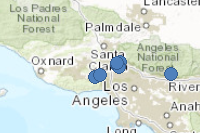

In [44]:
# get the webmap for at risk facilities, using it's id
webmapitem = gis.content.get('332c9b262522427cbd90e52edaec6209')
webmapitem

In [45]:
# create a webmap from the item
webmap = arcgis.mapping.WebMap(webmapitem)

In [46]:
# read the operational layers in our webmap
for lyr in webmap['operationalLayers']:
    if lyr['id'].startswith('At_Risk_Infrastructure'):
        print(lyr['url'])

http://ESRIwebgis.webgistesting.net/server/rest/services/Hosted/At_Risk_Infrastructure_2017_03_10_10_40_56/FeatureServer/0


In [47]:
new_url = at_risk_facilities.url
new_url

'http://ESRIwebgis.webgistesting.net/server/rest/services/Hosted/At_Risk_Infrastructure_2017_03_10_13_22_52/FeatureServer/0'

In [48]:
# update the url of the 'At Risk Infrastructure' layer in the web map

for lyr in webmap['operationalLayers']:
    if lyr['id'].startswith('At_Risk_Infrastructure'):
        lyr['url'] = new_url

In [49]:
# save the updates back to the GIS
webmap.update()

Web map items can also be visualized in the Jupyter Notebook as shown below. This enables use of web-maps for analysis and visualization within the notebook environment.

In [51]:
gis.map(webmapitem)